In [1]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
! pip install numpy scipy matplotlib quantiphy

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import scipy.integrate
from scipy.spatial.transform import Rotation as R
from quantiphy import Quantity as q

Defaulting to user installation because normal site-packages is not writeable


Environment

In [2]:
environment = {};
environment["pressure"] = 101.3e3; #Pa
environment["temperature"] = 10; #Deg C
environment["absolute_temp"] = environment["temperature"] + 273.15;
environment["dynamic_viscosity"] = 1.778e-5; #m^2/s


environment["ideal_gas_constant"] = 287.05; #J/Kg K

environment["air_density"] = (environment["pressure"])/(environment["absolute_temp"] * environment["ideal_gas_constant"]); #kg/m^3
environment["gravity"] = 9.81; #m/s^2
environment["wind_speed"] = [0, 0, 0]; #m/s


Math Tools

In [3]:
def VectorMagnitude(vector):
    v = vector
    magnitude = np.sqrt(np.dot(v,v))
    return magnitude

def RotationMatrix3d(alpha, beta, gamma):
    
    alpha = np.radians(alpha)
    beta = np.radians(beta)
    gamma = np.radians(gamma)
    #alpha : rotates about x (yaw)
    #beta  : rotates about y (pitch)
    #gamma : rotates about z (roll)

    cGamma = np.cos(gamma)
    sGamma = np.sin(gamma)
    
    cBeta = np.cos(beta)
    sBeta = np.sin(beta)
    
    cAlpha = np.cos(alpha)
    sAlpha = np.sin(alpha)
    
    RotMat = [[cBeta*cGamma, sAlpha*sBeta*cGamma - cAlpha*sGamma, cAlpha*sBeta*cGamma + sAlpha*sGamma], [cBeta*sGamma, sAlpha*sBeta*cGamma + cAlpha*cGamma, cAlpha*sBeta*sGamma - sAlpha*cGamma], [-sBeta, sAlpha*cBeta, cAlpha*cBeta]]

    return RotMat

def Rotation3d(alpha, beta, gamma, vector):
    rotMat = RotationMatrix3d(alpha, beta, gamma)
    RotVec = np.matmul(vector,rotMat)
    return RotVec


Physics Calculations

In [4]:
def ReynoldsNumber(characteristic_length, velocity):
    return (environment["air_density"] * velocity * characteristic_length)/environment["dynamic_viscosity"]

def SkinFrictionDragCoefficient(characteristic_length, velocity):
    Re = ReynoldsNumber(characteristic_length, velocity)
    transitionRe = 5e5;

    if Re == 0:
        Cf = 0

    elif Re < transitionRe:
        Cf = 1.328 / (np.sqrt(Re))

    else:
        CfL = 1.328 / (np.sqrt(Re))
        CfT = 0.0725 / (Re ** (1/5))
        Cf = CfT - (transitionRe/Re) * (CfT - CfL)
    
    return Cf

Solid Motor

In [5]:
solidmotor = {};
solidmotor["burn_time"] = 0.85; #s
solidmotor["peak_thrust_time"] = 0.18; #s
solidmotor["average_thrust_start"] = 0.3; #s
solidmotor["average_thrust_end"] = 0.8; #s
solidmotor["parachute_delay"] = 4;
solidmotor["total_impulse"] = 5; #N*s
solidmotor["motor_detonation"] = solidmotor["burn_time"] + solidmotor["parachute_delay"]

solidmotor["motor_variation"] = 1

solidmotor["max_thrust"] = 12.1 #N
solidmotor["average_thrust"] = solidmotor["motor_variation"] * (solidmotor["total_impulse"]/solidmotor["burn_time"])

solidmotor["propellant_mass"] = 6.24e-3; #kg
solidmotor["initial_mass"] = 20.1e-3; #kg
solidmotor["empty_mass"] = solidmotor["initial_mass"] - solidmotor["propellant_mass"]

solidmotor["burn_rate"] = solidmotor["propellant_mass"]/solidmotor["burn_time"]

Thrust Table

In [6]:
def ThrustTableGeneration(solidmotor):
  load_times = [0, solidmotor["peak_thrust_time"], solidmotor["average_thrust_start"], solidmotor["average_thrust_end"], solidmotor["burn_time"]]
  load_profile =  np.multiply(solidmotor["motor_variation"],[0, solidmotor["max_thrust"], solidmotor["average_thrust"], solidmotor["average_thrust"], 0])

  return np.column_stack((load_times,load_profile))

def ThrustForce(chart, time):
  thrust = np.interp(time, chart[:,0], chart[:,1])
  return thrust
  
solidmotor["thrust_function"] = ThrustTableGeneration(solidmotor)

Thrust Chart

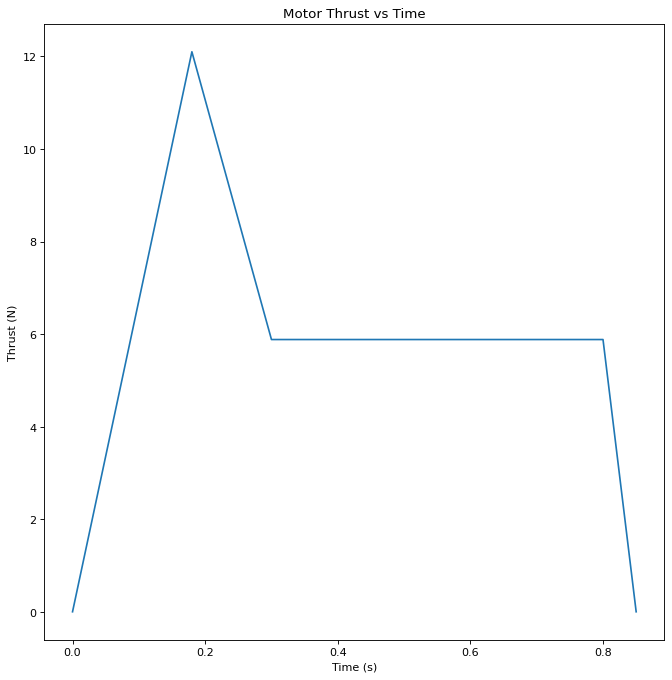

In [7]:
yfig = 10;
xfig = 10;
plt.figure(num=1, figsize=(xfig,yfig), dpi=80)
# plt.axhline(0, color='red')
plt.plot(solidmotor["thrust_function"][:,0], solidmotor["thrust_function"][:,1])
plt.title('Motor Thrust vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Thrust (N)')
plt.show()

Rocket Properties

In [8]:
rocket = {};
rocket["mass"] = 55e-3; #kg

rocket["diameter"] = 31.75e-3; #m
rocket["fuselage_length"] = 423e-3 #m

rocket["drag_coefficient"] = 1.05;
rocket["motor_off_drag_coefficient"] = 1.05;

rocket["wet_mass"] = rocket["mass"] + solidmotor["initial_mass"]
rocket["load_dry_mass"] = rocket["mass"] + solidmotor["initial_mass"] - solidmotor["propellant_mass"]

Fin Visualizer

In [9]:
fin = {};

fin["chord"] = [60e-3, 24e-3]; #m
fin["span"] = 45e-3; #m
fin["wing_sweep"] = 60e-3; #m
fin["thickness"] = 1.85e-3; #m
fin["option"] = 0;
fin["leading_edge_distance_to_fuselage_end"] = 10e-3 + fin["chord"][0]; #m

def finGenerator(option, sweepDistance):
    fin_granularity = 100;

    if option == 0: # Trapezoidal Wing
        sweepDistance =  0.5 * (fin["chord"][0] - fin["chord"][1])
        p0 = [0, 0]
        p1 = [sweepDistance, fin["span"]]
        p2 = [sweepDistance + fin["chord"][1], fin["span"]]
        p3 = [fin["chord"][0], 0]

        y_leading = np.linspace(0, fin["span"], fin_granularity)

        x_leading = np.linspace(p0[0], p1[0], fin_granularity)
        x_trailing = np.linspace(p3[0], p2[0], fin_granularity)


        return np.column_stack((x_leading, y_leading, x_trailing, y_leading))

    elif option == 1: # Arbitrary Wing Geometry
        p0 = [0, 0]
        p1 = [sweepDistance, fin["span"]]
        p2 = [sweepDistance + fin["chord"][1], fin["span"]]
        p3 = [fin["chord"][0], 0]

        y_leading = np.linspace(0, fin["span"], fin_granularity)
        
        x_leading = np.linspace(p0[0], p1[0], fin_granularity)
        x_trailing = np.linspace(p3[0], p2[0], fin_granularity)
        y_trailing = y_leading
        return np.column_stack((x_leading, y_leading, x_trailing, y_trailing))

def finArea():
    rootChord = fin["chord"][0]
    tipChord = fin["chord"][1]
    wingSpan = fin["span"]
    area = 0.5 * (rootChord + tipChord) * wingSpan
    
    return area

fin["geometry"] = finGenerator(fin["option"], fin["wing_sweep"])
fin["area"] = finArea()

def finPlotGeometry():
    x_pts = np.concatenate((fin["geometry"][:,0],np.flip(fin["geometry"][:,2])))
    y_pts = np.concatenate((fin["geometry"][:,1],np.flip(fin["geometry"][:,3])))
    return np.column_stack((x_pts, y_pts))

fin["plotGeo"] = finPlotGeometry()

def finChordOverSpan():
    chordLength = np.zeros(len(fin["geometry"][:,0]));
    spanDist = np.linspace(0, fin["span"], len(chordLength))
    for i in range(0, len(chordLength)):
        chordLength[i] = fin["geometry"][i,2] - fin["geometry"][i,0]
    return np.column_stack((spanDist, chordLength))

fin["wing_chord"] = finChordOverSpan()

def midChordLine():
    midLine = np.add(np.divide(fin["wing_chord"][:,1], 2), fin["geometry"][:,0])
    return np.column_stack((fin["wing_chord"][:,0], midLine))

fin["MAC"] = midChordLine()

def midChordLineLength():
    midPoint1 = np.array([fin["MAC"][0,0], fin["MAC"][0,1]])
    midPoint2 = np.array([fin["MAC"][-1,0], fin["MAC"][-1,1]])
    dist = np.linalg.norm(midPoint2 - midPoint1)
    return dist

fin["MAC_length"] = midChordLineLength()

def centerOfArea():
    numerator = np.sum(np.multiply(fin["MAC"],fin["wing_chord"]))
    denominator = np.sum(fin["wing_chord"])
    x_center = np.divide(numerator, denominator)
    return x_center

fin["x_Center"] = centerOfArea()

Wing Calculations

In [10]:
def FlatPlateLiftCoefficient(angle):
    FPCl = 2 * np.pi * np.sin(np.radians(angle))
    return FPCl

Fin Graph

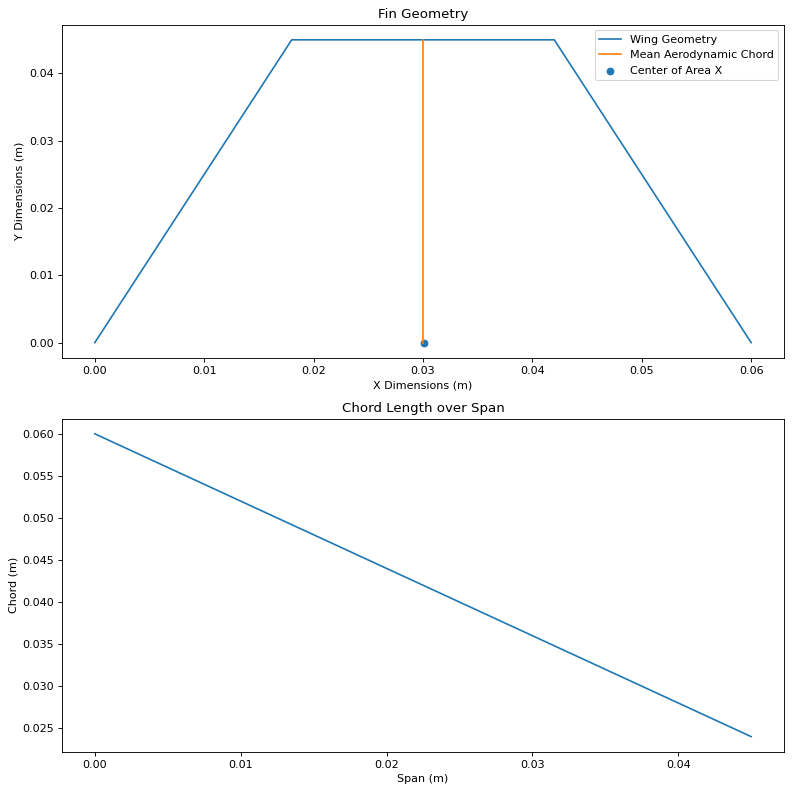

In [11]:
yfig = 10;
xfig = 10;
plt.figure(num=1, figsize=(xfig,yfig), dpi=80)
plt.subplot(211)
plt.plot(fin["plotGeo"][:,0], fin["plotGeo"][:,1], label="Wing Geometry")
plt.plot(fin["MAC"][:,1], fin["MAC"][:,0], label="Mean Aerodynamic Chord")
plt.scatter(fin["x_Center"], 0, label="Center of Area X")
plt.legend()
plt.title('Fin Geometry')
plt.xlabel('X Dimensions (m)')
plt.ylabel('Y Dimensions (m)')

plt.figure(num=1, figsize=(xfig,yfig), dpi=80)
plt.subplot(212)
plt.plot(fin["wing_chord"][:,0], fin["wing_chord"][:,1])
plt.title('Chord Length over Span')
plt.xlabel('Span (m)')
plt.ylabel('Chord (m)')

plt.tight_layout()

Nose Cone Properties

In [12]:
noseCone = {};

noseCone["length"] = 50e-3; #m

def noseConeGeometry(option):
    granularity = 20;

    if option == 0: #Conical Nose Cone
        x_pts = np.linspace(0, noseCone["length"], granularity)
        ctrl_params = [0.5 * rocket["diameter"], 0]
        ctrl_poly = np.polyfit(np.linspace(0, noseCone["length"], len(ctrl_params)), ctrl_params, len(ctrl_params) - 1)
        y_pts = np.polyval(ctrl_poly, x_pts)
        return ctrl_poly, np.column_stack((x_pts, y_pts))

    if option == 1: #Parabolic Arc
        x_pts = np.linspace(0, noseCone["length"], granularity)
        ctrl_params = [0.5 * rocket["diameter"], 0.375 * rocket["diameter"], 0]
        ctrl_poly = np.polyfit(np.linspace(0, noseCone["length"], len(ctrl_params)), ctrl_params, len(ctrl_params) - 1)
        y_pts = np.polyval(ctrl_poly, x_pts)
        return ctrl_poly, np.column_stack((x_pts, y_pts))

noseCone["ctrl_poly"], noseCone["geometry"] = noseConeGeometry(1)

def noseConeArea():
    granularity = 10000

    ctrl_poly = noseCone["ctrl_poly"]
    x_coords = np.linspace(0, noseCone["length"], granularity)
    y_coords = np.polyval(ctrl_poly, x_coords)

    area = 2 * np.pi * np.trapz(y_coords, x_coords)
    return area

noseCone["area"] = noseConeArea()

Nose Cone Plot

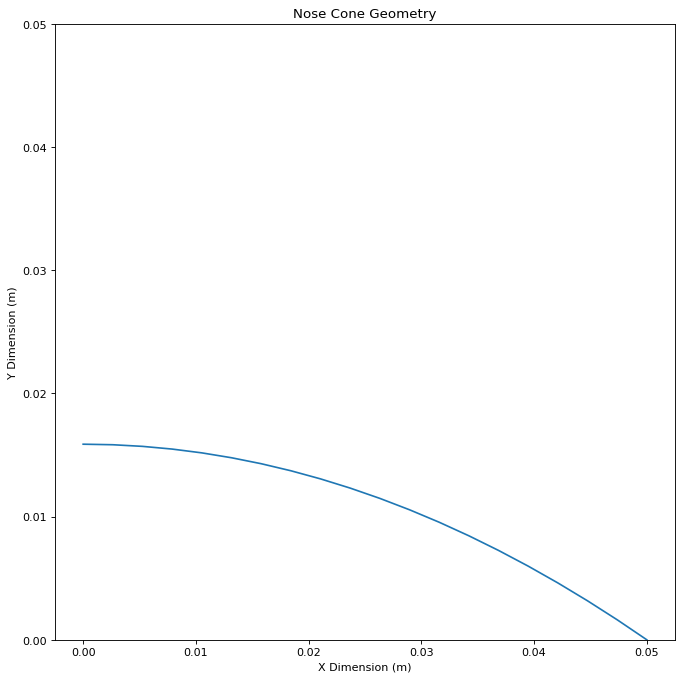

In [13]:
yfig = 10;
xfig = 10;
plt.figure(num=1, figsize=(xfig,yfig), dpi=80)
plt.plot(noseCone["geometry"][:,0], noseCone["geometry"][:,1])
plt.title('Nose Cone Geometry')
plt.ylim(0,noseCone["length"])
plt.xlabel('X Dimension (m)')
plt.ylabel('Y Dimension (m)')
plt.show()

Rocket Area Calculation

In [14]:
rocket["number_of_fins"] = 3;

rocket["total_length"] = noseCone["length"] + rocket["fuselage_length"]
rocket["frontal_area"] = 0.25 * np.pi * (rocket["diameter"]) ** 2 + rocket["number_of_fins"] * fin["thickness"] * fin["span"]
rocket["surface_area"] = (np.pi * rocket["diameter"]) * rocket["fuselage_length"] + 2 * rocket["number_of_fins"] * fin["area"] + noseCone["area"]

rocket["side_area"] = rocket["diameter"] * rocket["fuselage_length"]

Rocket Visualizer

In [15]:
def rocketFuselagePlotCoords():
    x = [0, 0, rocket["fuselage_length"], rocket["fuselage_length"]]
    y = [0, 0.5 * rocket["diameter"], 0.5 * rocket["diameter"], 0]
    return np.column_stack((x,y))

rocket["fuselage_plot_geo"] = rocketFuselagePlotCoords()
fin["plot_geometry"] = np.column_stack((np.add(fin["leading_edge_distance_to_fuselage_end"], np.negative(fin["plotGeo"][:,0])), np.add(0.5 * rocket["diameter"], fin["plotGeo"][:,1])))
noseCone["plot_geometry"] = np.column_stack((np.add(rocket["fuselage_length"], noseCone["geometry"][:,0]), noseCone["geometry"][:,1]))

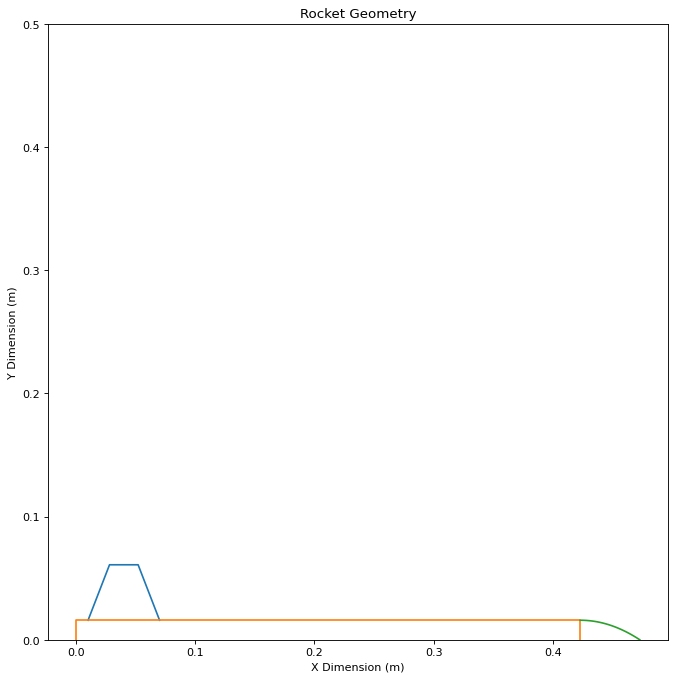

In [16]:
yfig = 10;
xfig = 10;
plt.figure(num=1, figsize=(xfig,yfig), dpi=80)
plt.plot(fin["plot_geometry"][:,0], fin["plot_geometry"][:,1])
plt.plot(rocket["fuselage_plot_geo"][:,0],rocket["fuselage_plot_geo"][:,1])
plt.plot(noseCone["plot_geometry"][:,0],noseCone["plot_geometry"][:,1])
plt.title('Rocket Geometry')
plt.ylim(0, 0.5)
plt.xlabel('X Dimension (m)')
plt.ylabel('Y Dimension (m)')
plt.show()

Rocket Data

In [17]:
rocket["current_mass"] = [];

rocket["x_flight_position"] = [];
rocket["x_flight_velocity"] = [];
rocket["y_flight_position"] = [];
rocket["y_flight_velocity"] = [];
rocket["z_flight_position"] = [];
rocket["z_flight_velocity"] = [];

rocket["roll_angle"]  = [];
rocket["roll_rate"]   = [];
rocket["yaw_angle"]   = [];
rocket["yaw_rate"]    = [];
rocket["pitch_angle"] = [];
rocket["pitch_rate"]  = [];

rocket["flight_time"] = [];
rocket["air_pitch"]   = [];

Launcher Properties

In [18]:
launcher = {};
launcher["height"] = 0.5; #m
launcher["alpha_angle"] = 1; #degrees
launcher["beta_angle"] = -1; # degrees
launcher["gamma_angle"] = 0;

Parachute Properties

In [19]:
parachute = {};
parachute["mass"] = 2e-3; #kg 
parachute["outer_radius"] = 100e-3; #m
parachute["inner_radius"] = 0; #m

parachute["drag_coefficient"] = 1.75
parachute["area"] = np.pi*(parachute["outer_radius"] ** 2 - parachute["inner_radius"] ** 2)
parachute["initial_area"] = 0.25 * np.pi * (rocket["diameter"]) ** 2

parachute["steady_descent_velocity"] = np.sqrt((2 * rocket["load_dry_mass"] * environment["gravity"]) / (parachute["drag_coefficient"] * parachute["area"] * environment["air_density"]))

Aerodynamics Processes

In [20]:
def AngleOfAttack(airVelocityVector, bodyVelocityVector):
    AoA = np.degrees(np.arctan2(airVelocityVector, abs(bodyVelocityVector)))
    return AoA

Solver

In [21]:
#Only uncomment ONE at a time for solver types

# solver_type = "RK45"
# solver_type = "RK23"
# solver_type = "DOP853"
# solver_type = "Radau"
# solver_type = "BDF"
solver_type = "LSODA"

#Keep this a small number
step_max = 0.005;

Initial Conditions

In [22]:
initialCondition = {};

initialCondition["rocket_mass"] = rocket["wet_mass"]
initialCondition["x_pos"] = 0;
initialCondition["x_vel"] = 0;
initialCondition["y_pos"] = 0;
initialCondition["y_vel"] = 0;
initialCondition["z_pos"] = 0;
initialCondition["z_vel"] = 0;

initialCondition["yaw_angle"]   = 0;
initialCondition["yaw_rate"]    = 0;
initialCondition["pitch_angle"] = 0;
initialCondition["pitch_rate"]  = 0;
initialCondition["roll_angle"]  = 0;
initialCondition["roll_rate"]   = 0;

initialCondition["start_time"] = 0;
initialCondition["end_time"] = 10;
initialCondition["max_burn_time"] = solidmotor["burn_time"]
initialCondition["max_sim_time"] = 120;

initialCondition["time_span"] = [initialCondition["start_time"],solidmotor["burn_time"]]
initialCondition["motorDetonation"] = solidmotor["burn_time"] + solidmotor["parachute_delay"]

Aerodynamic Drag Forces

In [23]:
# Option Zero is data pulled from RASAero II
# Option One is DATCOM Method V1
# Option Two is Barrowman Method

def BaseDragCoefficient(velocity, option):
    db = rocket["diameter"]
    dd = rocket["diameter"]

    if option == 0:
        cD = rocket["drag_coefficient"];

    if option == 1:
        if BodyDragCoefficient(velocity, 1) == 0:
            cD = 0
        else:
            cD = (0.029 * (dd/db) ** 3)/ (np.sqrt(BodyDragCoefficient(velocity, 1)))
    return cD

def BodyDragCoefficient(velocity, option):
    p = np.zeros(5)
    lTr = rocket["total_length"]
    ln = noseCone["length"]
    lb = rocket["fuselage_length"]
    db = rocket["diameter"]
    dd = rocket["diameter"]
    lc = 0

    if option == 0:
        length_TR = rocket["total_length"]
        cD = SkinFrictionDragCoefficient(length_TR, velocity) * (rocket["surface_area"]/rocket["frontal_area"])

    if option == 1:
        p[0] = 60 / ((lb/db) ** 3)
        p[1] = 0.0025 * (lb/db)
        p[2] = 2.7 * ln/db
        p[3] = 4 * lb/db
        p[4] = 2 * (1 - dd/db) * (lc/db)

        if velocity == 0:
            cD = 0
        else:
            cD = 4.75 * (1 + p[0] + p[1]) * (p[2] + p[3] + p[4]) * SkinFrictionDragCoefficient(lTr, velocity);
        return cD

def FinDragCoefficient(velocity, option):
    if option == 0:
        cD = 0

    if option == 1:
        n = rocket["number_of_fins"]
        Tf = fin["thickness"]
        lMAC = fin["MAC_length"]
        Afp = fin["area"] + 0.5 * rocket["diameter"] * fin["chord"][0]
        df = rocket["diameter"]
        Cf = SkinFrictionDragCoefficient(rocket["total_length"], velocity)

        cD = 2 * Cf * (1 + 2 * (Tf/lMAC)) * (4 * n * Afp)/(np.pi * df ** 2)
    return cD

def InterferenceDragCoefficient(velocity, option):
    if option == 0:
        cD = 0;

    if option == 1:
        n = rocket["number_of_fins"]
        Tf = fin["thickness"]
        lMAC = fin["MAC_length"]
        Afd = 0.5 * rocket["diameter"] * fin["chord"][0]
        df = rocket["diameter"]
        Cf = SkinFrictionDragCoefficient(rocket["fuselage_length"] + noseCone["length"], velocity)

        cD = 2 * Cf * (1 + 2 * Tf/lMAC) * (4 * n * Afd)/(np.pi * df ** 2)
    return cD


Force Calculation

In [24]:
def DragForce(velocity, option):
    v = VectorMagnitude(velocity)
    option = 1
    BaseDragCoeffOption = option
    BodyDragCoeffOption = option
    FinDragCoeffOption = option
    InterferenceDragCoeffOption = option

    if option == 0:
        cDBodyDrag = BodyDragCoefficient(v, BodyDragCoeffOption)
        cDBaseDrag = BaseDragCoefficient(v, BaseDragCoeffOption)
        cDFinDrag = FinDragCoefficient(v, FinDragCoeffOption)
        cDInterferenceDrag = InterferenceDragCoefficient(v, InterferenceDragCoeffOption)
        Cd = cDBodyDrag + cDBaseDrag + cDFinDrag + cDInterferenceDrag

    if option == 1:
        cDBodyDrag = BodyDragCoefficient(v, BodyDragCoeffOption)
        cDBaseDrag = BaseDragCoefficient(v, BaseDragCoeffOption)
        cDFinDrag = FinDragCoefficient(v, FinDragCoeffOption)
        cDInterferenceDrag = InterferenceDragCoefficient(v, InterferenceDragCoeffOption)
        Cd = cDBodyDrag + cDBaseDrag + cDFinDrag + cDInterferenceDrag

    dragForce = 0.5 * (Cd) * rocket["frontal_area"] * environment["air_density"] * v ** 2

    return dragForce

def GravityForce(mass, environment):
    gravity = environment["gravity"]
    force = mass * gravity
    return force

def ParaDragForce(environment, parachute, velocity):
    v = velocity[2]
    force = (0.5 * parachute["drag_coefficient"] * parachute["area"] * environment["air_density"]) * v ** 2
    return force

def DragForceVector(velocity, yaw_angle, pitch_angle, roll_angle, option):
    drag_force_body = [0, 0, -DragForce(velocity, option)]
    drag_vector = Rotation3d(yaw_angle, pitch_angle, roll_angle, drag_force_body)
    return drag_vector

def ThrustForceVector(time, yaw_angle, pitch_angle, roll_angle):
    thrust_body = [0, 0, ThrustForce(solidmotor["thrust_function"], time)]
    thrust_vector = Rotation3d(yaw_angle, pitch_angle, roll_angle, thrust_body)
    return thrust_vector

Flight Models

In [25]:

def RocketUnderThrustOnRail(t,y):
  rocket["current_mass"].append(y[0])

  rocket["x_flight_position"].append(y[1])
  rocket["x_flight_velocity"].append(y[2])

  rocket["y_flight_position"].append(y[3])
  rocket["y_flight_velocity"].append(y[4])

  rocket["z_flight_position"].append(y[5])
  rocket["z_flight_velocity"].append(y[6])

  rocket["yaw_angle"].append(y[7])
  rocket["yaw_rate"].append(y[8])

  rocket["pitch_angle"].append(y[9])
  rocket["pitch_rate"].append(y[10])
  rocket["air_pitch"].append(0)

  rocket["roll_angle"].append(y[11])
  rocket["roll_rate"].append(y[12])

  rocket["flight_time"].append(t)
  
  velocity = [y[2], y[4], y[6]]


  drag_force = DragForceVector(velocity, launcher["alpha_angle"], launcher["beta_angle"], launcher["gamma_angle"], 0)
  thrust_force = ThrustForceVector(t, launcher["alpha_angle"], launcher["beta_angle"], launcher["gamma_angle"])
  gravity_force = y[0] * environment["gravity"]

  mass_rate = -solidmotor["burn_rate"] #mass burn rate

  x_vel = y[2] #x velocity  
  x_accel = np.reciprocal(y[0]) * (thrust_force[0] + np.sign(y[2]) * drag_force[0]) #x acceleration

  y_vel = y[4] #y velocity  
  y_accel = np.reciprocal(y[0]) * (thrust_force[1] + np.sign(y[4]) * drag_force[1]) #y acceleration

  z_vel = y[6] #z velocity
  z_accel = np.reciprocal(y[0]) * (thrust_force[2] + np.sign(y[6]) * drag_force[2] - gravity_force) #z acceleration
  
  yaw_rate = y[8] #yaw rate
  yaw_accel = 0 #yaw moment

  pitch_rate = y[10] #pitch rate
  pitch_accel = 0 #pitch moment

  roll_rate = y[12] #roll rate
  roll_accel = 0 #roll moment

  StateSpace = [mass_rate, x_vel, x_accel, y_vel, y_accel, z_vel, z_accel, yaw_rate, yaw_accel, pitch_rate, pitch_accel, roll_rate, roll_accel]
  return StateSpace

In [26]:
def RocketUnderThrust(t,y):
  rocket["current_mass"].append(y[0])

  rocket["x_flight_position"].append(y[1])
  rocket["x_flight_velocity"].append(y[2])

  rocket["y_flight_position"].append(y[3])
  rocket["y_flight_velocity"].append(y[4])

  rocket["z_flight_position"].append(y[5])
  rocket["z_flight_velocity"].append(y[6])

  rocket["yaw_angle"].append(y[7])
  rocket["yaw_rate"].append(y[8])

  rocket["pitch_angle"].append(y[9])
  rocket["pitch_rate"].append(y[10])

  rocket["roll_angle"].append(y[11])
  rocket["roll_rate"].append(y[12])

  rocket["flight_time"].append(t)

  velocity = [y[2] - environment["wind_speed"][0], y[4] - environment["wind_speed"][1], y[6]]
  
  air_pitch = AngleOfAttack(environment["wind_speed"][0], y[6])
  rocket["air_pitch"].append(air_pitch)

  drag_force = DragForceVector(velocity, launcher["alpha_angle"], launcher["beta_angle"], launcher["gamma_angle"], 0)
  thrust_force = ThrustForceVector(t, launcher["alpha_angle"], launcher["beta_angle"], launcher["gamma_angle"])
  gravity_force = y[0] * environment["gravity"]

  mass_rate = -solidmotor["burn_rate"] #mass burn rate

  x_vel = y[2] #x velocity  
  x_accel = np.reciprocal(y[0]) * (thrust_force[0] + np.sign(y[2]) * drag_force[0]) #x acceleration
  
  y_vel = y[4] #y velocity  
  y_accel = np.reciprocal(y[0]) * (thrust_force[1] + np.sign(y[4]) * drag_force[1]) #y acceleration

  z_vel = y[6] #z velocity
  z_accel = np.reciprocal(y[0]) * (thrust_force[2] + np.sign(y[6]) * drag_force[2] - gravity_force) #z acceleration
    
  yaw_rate = y[8] #yaw rate
  yaw_accel = 0 #yaw moment

  pitch_rate = y[10] #pitch rate
  pitch_accel = 0 #pitch moment

  roll_rate = y[12] #roll rate
  roll_accel = 0 #roll moment

  StateSpace = [mass_rate, x_vel, x_accel, y_vel, y_accel, z_vel, z_accel, yaw_rate, yaw_accel, pitch_rate, pitch_accel, roll_rate, roll_accel]
  return StateSpace

In [27]:
def RocketFreeFall(t,y):
  rocket["current_mass"].append(y[0])

  rocket["x_flight_position"].append(y[1])
  rocket["x_flight_velocity"].append(y[2])

  rocket["y_flight_position"].append(y[3])
  rocket["y_flight_velocity"].append(y[4])

  rocket["z_flight_position"].append(y[5])
  rocket["z_flight_velocity"].append(y[6])

  rocket["yaw_angle"].append(y[7])
  rocket["yaw_rate"].append(y[8])

  rocket["pitch_angle"].append(y[9])
  rocket["pitch_rate"].append(y[10])

  rocket["roll_angle"].append(y[11])
  rocket["roll_rate"].append(y[12])

  rocket["flight_time"].append(t)
  
  velocity = [y[2] - environment["wind_speed"][0], y[4] - environment["wind_speed"][1], y[6]]

  air_pitch = AngleOfAttack(environment["wind_speed"][0], y[6])
  rocket["air_pitch"].append(air_pitch)

  drag_force = DragForceVector(velocity, launcher["alpha_angle"], launcher["beta_angle"], launcher["gamma_angle"], 1)
  gravity_force = y[0] * environment["gravity"]

  mass_rate = 0 #mass burn rate

  x_vel = y[2] #x velocity  
  x_accel = np.reciprocal(y[0]) * (np.sign(y[2]) * drag_force[0]) #x acceleration

  y_vel = y[4] #y velocity  
  y_accel = np.reciprocal(y[0]) * (np.sign(y[4]) * drag_force[1]) #y acceleration

  z_vel = y[6] #z velocity
  z_accel = np.reciprocal(y[0]) * (np.sign(y[6]) * drag_force[2] - gravity_force) #z acceleration
    
  yaw_rate = y[8] #yaw rate
  yaw_accel = 0 #yaw moment

  pitch_rate = y[10] #pitch rate
  pitch_accel = 0 #pitch moment

  roll_rate = y[12] #roll rate
  roll_accel = 0 #roll moment

  StateSpace = [mass_rate, x_vel, x_accel, y_vel, y_accel, z_vel, z_accel, yaw_rate, yaw_accel, pitch_rate, pitch_accel, roll_rate, roll_accel]
  return StateSpace

In [28]:
def RocketUnderParachute(t,y):
  rocket["current_mass"].append(y[0])

  rocket["x_flight_position"].append(y[1])
  rocket["x_flight_velocity"].append(y[2])

  rocket["y_flight_position"].append(y[3])
  rocket["y_flight_velocity"].append(y[4])

  rocket["z_flight_position"].append(y[5])
  rocket["z_flight_velocity"].append(y[6])

  rocket["yaw_angle"].append(y[7])
  rocket["yaw_rate"].append(y[8])

  rocket["pitch_angle"].append(y[9])
  rocket["pitch_rate"].append(y[10])

  rocket["roll_angle"].append(y[11])
  rocket["roll_rate"].append(y[12])

  rocket["flight_time"].append(t)

  velocity = [y[2] - environment["wind_speed"][0], y[4] - environment["wind_speed"][1], y[6]]

  drag_force = DragForceVector(velocity, launcher["alpha_angle"], launcher["beta_angle"], launcher["gamma_angle"],1)
  para_drag_force = [0, 0, -ParaDragForce(environment, parachute, velocity)]
  gravity_force = y[0] * environment["gravity"]

  mass_rate = 0 #mass burn rate
  
  x_vel = y[2] #x velocity
  x_accel = np.reciprocal(y[0]) * (drag_force[0]) #x acceleration

  y_vel = y[4] #x velocity  
  y_accel = np.reciprocal(y[0]) * (drag_force[1]) #x acceleration

  z_vel = y[6] #z velocity
  z_accel = np.reciprocal(y[0]) * (np.sign(y[6]) * (para_drag_force[2] + drag_force[2]) - gravity_force) #z acceleration
  
  yaw_rate = y[8] #yaw rate
  yaw_accel = 0 #yaw moment

  pitch_rate = y[10] #pitch rate
  pitch_accel = 0 #pitch moment

  roll_rate = y[12] #roll rate
  roll_accel = 0 #roll moment

  StateSpace = [mass_rate, x_vel, x_accel, y_vel, y_accel, z_vel, z_accel, yaw_rate, yaw_accel, pitch_rate, pitch_accel, roll_rate, roll_accel]
  return StateSpace

Termination Conditions

In [29]:
def hit_rail(t, y): return (np.sqrt(y[1] ** 2 + y[2] ** 2 + y[5] ** 2) - launcher["height"] * np.cos(np.radians(launcher["alpha_angle"])))
hit_rail.terminal = True;
hit_rail.direction = 1;

def hit_ground(t, y): return y[5]
hit_ground.terminal = True;
hit_ground.direction = -1;

def motor_burnout(t,y): return (y[0] - rocket["load_dry_mass"])
motor_burnout.terminal = True;
motor_burnout.direction = -1;

Launch Rail Solution

In [30]:
def MotionOnRail(model):
    t_span = initialCondition["time_span"]
    rocket["rail_motion"] = sp.integrate.solve_ivp(model, t_span, initialCondition["IC"],dense_output=True, max_step = step_max, events = hit_rail, method=solver_type); #model = RocketUnderThrust
    
    sim_time = np.interp(launcher["height"], rocket["z_flight_position"], rocket["flight_time"])
    mass  = np.interp(sim_time,rocket["flight_time"], rocket["current_mass"])

    x_pos = np.interp(sim_time,rocket["flight_time"], rocket["x_flight_position"])
    x_vel = np.interp(sim_time,rocket["flight_time"], rocket["x_flight_velocity"])

    y_pos = np.interp(sim_time,rocket["flight_time"], rocket["y_flight_position"])
    y_vel = np.interp(sim_time,rocket["flight_time"], rocket["y_flight_velocity"])
    
    z_pos = np.interp(sim_time,rocket["flight_time"], rocket["z_flight_position"])
    z_vel = np.interp(sim_time,rocket["flight_time"], rocket["z_flight_velocity"])
    
    yaw_angle = np.interp(sim_time,rocket["flight_time"], rocket["yaw_angle"])
    yaw_rate  = np.interp(sim_time,rocket["flight_time"], rocket["yaw_rate"])

    pitch_angle = np.interp(sim_time,rocket["flight_time"], rocket["pitch_angle"])
    pitch_rate  = np.interp(sim_time,rocket["flight_time"], rocket["pitch_rate"])
    
    roll_angle = np.interp(sim_time,rocket["flight_time"], rocket["roll_angle"])
    roll_rate  = np.interp(sim_time,rocket["flight_time"], rocket["roll_rate"])
    
    return mass, x_pos, x_vel, y_pos, y_vel, z_pos, z_vel, yaw_angle, yaw_rate, pitch_angle, pitch_rate, roll_angle, roll_rate, sim_time


Motion Until Burnout

In [31]:
def MotionUnderThrust(model):
    t_span = initialCondition["time_span"]
    rocket["motion_free_Thrust"] = sp.integrate.solve_ivp(model, t_span, initialCondition["IC"],dense_output=True, max_step = step_max, events = motor_burnout, method=solver_type); #model = RocketUnderThrust
    
    sim_time = np.interp(max(rocket["z_flight_position"]), rocket["z_flight_position"], rocket["flight_time"])
    mass  = np.interp(sim_time,rocket["flight_time"], rocket["current_mass"])

    x_pos = np.interp(sim_time,rocket["flight_time"], rocket["x_flight_position"])
    x_vel = np.interp(sim_time,rocket["flight_time"], rocket["x_flight_velocity"])

    y_pos = np.interp(sim_time,rocket["flight_time"], rocket["y_flight_position"])
    y_vel = np.interp(sim_time,rocket["flight_time"], rocket["y_flight_velocity"])
    
    z_pos = np.interp(sim_time,rocket["flight_time"], rocket["z_flight_position"])
    z_vel = np.interp(sim_time,rocket["flight_time"], rocket["z_flight_velocity"])

    yaw_angle = np.interp(sim_time,rocket["flight_time"], rocket["yaw_angle"])
    yaw_rate  = np.interp(sim_time,rocket["flight_time"], rocket["yaw_rate"])

    pitch_angle = np.interp(sim_time,rocket["flight_time"], rocket["pitch_angle"])
    pitch_rate  = np.interp(sim_time,rocket["flight_time"], rocket["pitch_rate"])
    
    roll_angle = np.interp(sim_time,rocket["flight_time"], rocket["roll_angle"])
    roll_rate  = np.interp(sim_time,rocket["flight_time"], rocket["roll_rate"])
    
    return mass, x_pos, x_vel, y_pos, y_vel, z_pos, z_vel, yaw_angle, yaw_rate, pitch_angle, pitch_rate, roll_angle, roll_rate, sim_time


Motion in Freefall

In [32]:
def MotionInFreeFall(model):
    t_span = initialCondition["time_span"]
    rocket["motion_Free_fall"] = sp.integrate.solve_ivp(model, t_span, initialCondition["IC"], dense_output=True, max_step = step_max, method=solver_type); #model = RocketFreeFall
    
    sim_time = np.interp(max(rocket["z_flight_position"]), rocket["z_flight_position"], rocket["flight_time"])
    mass  = np.interp(sim_time,rocket["flight_time"], rocket["current_mass"])

    x_pos = np.interp(sim_time,rocket["flight_time"], rocket["x_flight_position"])
    x_vel = np.interp(sim_time,rocket["flight_time"], rocket["x_flight_velocity"])

    y_pos = np.interp(sim_time,rocket["flight_time"], rocket["y_flight_position"])
    y_vel = np.interp(sim_time,rocket["flight_time"], rocket["y_flight_velocity"])
    
    z_pos = np.interp(sim_time,rocket["flight_time"], rocket["z_flight_position"])
    z_vel = np.interp(sim_time,rocket["flight_time"], rocket["z_flight_velocity"])
    
    yaw_angle = np.interp(sim_time,rocket["flight_time"], rocket["yaw_angle"])
    yaw_rate  = np.interp(sim_time,rocket["flight_time"], rocket["yaw_rate"])

    pitch_angle = np.interp(sim_time,rocket["flight_time"], rocket["pitch_angle"])
    pitch_rate  = np.interp(sim_time,rocket["flight_time"], rocket["pitch_rate"])
    
    roll_angle = np.interp(sim_time,rocket["flight_time"], rocket["roll_angle"])
    roll_rate  = np.interp(sim_time,rocket["flight_time"], rocket["roll_rate"])
    
    return mass, x_pos, x_vel, y_pos, y_vel, z_pos, z_vel, yaw_angle, yaw_rate, pitch_angle, pitch_rate, roll_angle, roll_rate, sim_time


Motion in Freefall with Detonation

In [33]:
def MotionInFreeFallWithDeployment(model):
    t_span = initialCondition["time_span"]
    rocket["motion_under_chute"] = sp.integrate.solve_ivp(model, t_span, initialCondition["IC"], dense_output=True, events = hit_ground, max_step = step_max, method=solver_type); #model = RocketUnderParachute
    
    sim_time = rocket["flight_time"][-1]
    mass  = rocket["current_mass"][-1]

    x_pos = rocket["x_flight_position"][-1]
    x_vel = rocket["x_flight_velocity"][-1]

    y_pos = rocket["y_flight_position"][-1]
    y_vel = rocket["y_flight_velocity"][-1]
    
    z_pos = rocket["z_flight_position"][-1]
    z_vel = rocket["z_flight_velocity"][-1]
    
    yaw_angle = np.interp(sim_time,rocket["flight_time"], rocket["yaw_angle"])
    yaw_rate  = np.interp(sim_time,rocket["flight_time"], rocket["yaw_rate"])

    pitch_angle = np.interp(sim_time,rocket["flight_time"], rocket["pitch_angle"])
    pitch_rate  = np.interp(sim_time,rocket["flight_time"], rocket["pitch_rate"])
    
    roll_angle = np.interp(sim_time,rocket["flight_time"], rocket["roll_angle"])
    roll_rate  = np.interp(sim_time,rocket["flight_time"], rocket["roll_rate"])
    
    return mass, x_pos, x_vel, y_pos, y_vel, z_pos, z_vel, yaw_angle, yaw_rate, pitch_angle, pitch_rate, roll_angle, roll_rate, sim_time

Full Simulation

In [34]:
def flightPathGeneration(initialCondition):
    initialCondition["time_span"] = [initialCondition["start_time"], solidmotor["burn_time"]]
    initialCondition["IC"] = [initialCondition["rocket_mass"], initialCondition["x_pos"], initialCondition["x_vel"], initialCondition["y_pos"], initialCondition["y_vel"], initialCondition["z_pos"], initialCondition["z_vel"], initialCondition["yaw_angle"], initialCondition["yaw_rate"], initialCondition["pitch_angle"], initialCondition["pitch_rate"], initialCondition["roll_angle"], initialCondition["roll_rate"]]
    EndState =  MotionOnRail(RocketUnderThrustOnRail)

    initialCondition["IC"] = EndState[0:-1]
    initialCondition["time_span"] = [EndState[-1], 1.1 * solidmotor["burn_time"]]
    EndState = MotionUnderThrust(RocketUnderThrust)

    initialCondition["IC"] = EndState[0:-1]
    initialCondition["time_span"] = [EndState[-1], solidmotor["motor_detonation"]]
    EndState = MotionInFreeFall(RocketFreeFall)

    initialCondition["IC"] = EndState[0:-1]
    initialCondition["time_span"] = [EndState[-1], initialCondition["max_sim_time"]]
    EndState = MotionInFreeFallWithDeployment(RocketUnderParachute)

    initialCondition["IC"] = EndState[0:-1]
    return initialCondition["IC"]

landingConditions = [];
landingConditions = flightPathGeneration(initialCondition)

Critical Points

In [35]:
rocket["apogee"] = max(rocket["z_flight_position"])

rocket["time_to_apogee"] = rocket["flight_time"][rocket["z_flight_position"].index(rocket["apogee"])]

rocket["x_pos_at_apogee"] = rocket["x_flight_position"][rocket["z_flight_position"].index(rocket["apogee"])]
rocket["y_pos_at_apogee"] = rocket["y_flight_position"][rocket["z_flight_position"].index(rocket["apogee"])]

Reaction Forces Analysis

In [36]:
rocket["velocity_profile"] = np.column_stack((rocket["x_flight_velocity"],rocket["y_flight_velocity"],rocket["z_flight_velocity"]))

a = rocket["velocity_profile"].shape

rocket["speed_profile"] = np.zeros(a[0])
skinDragCf = np.zeros(a[0])
Re = np.zeros(a[0])
skinDrag = np.zeros(a[0])
profileDrag = np.zeros(a[0])
totalDrag = np.zeros(a[0])
sDr = np.zeros(a[0])
pDr = np.zeros(a[0])
cDFlight = np.zeros(a[0])

for i in range(0,len(rocket["speed_profile"])):
    rocket["speed_profile"][i] = VectorMagnitude(rocket["velocity_profile"][:][i])

for i in range(0,len(rocket["speed_profile"])):
    skinDragCf[i] = SkinFrictionDragCoefficient(rocket["fuselage_length"], rocket["speed_profile"][i])
    # skinDragCf[i] = 0.029/(np.sqrt(SkinFrictionDragCoefficient(rocket["fuselage_length"] + noseCone["length"], rocket["speed_profile"][i])))


for i in range(0,len(rocket["speed_profile"])):
    Re[i] = ReynoldsNumber(rocket["fuselage_length"], rocket["speed_profile"][i])

for i in range(0,len(rocket["speed_profile"])):
    skinDrag[i] = 0.5 * skinDragCf[i] * rocket["frontal_area"] * environment["air_density"] * rocket["speed_profile"][i] ** 2

for i in range(0,len(rocket["speed_profile"])):
    profileDrag[i] = 0.5 * rocket["drag_coefficient"] * rocket["frontal_area"] * environment["air_density"] * rocket["speed_profile"][i] ** 2

for i in range(0,len(rocket["speed_profile"])):
    totalDrag[i] = skinDrag[i] + profileDrag[i]

for i in range(0,len(rocket["speed_profile"])):
    if totalDrag[i] == 0:
        sDr[i] = 0
    
    else:
        sDr[i] = skinDrag[i] / totalDrag[i]

for i in range(0,len(rocket["speed_profile"])):
    if totalDrag[i] == 0:
        pDr[i] = 0

    else:
        pDr[i] = profileDrag[i] / totalDrag[i]



Velocity Graphs

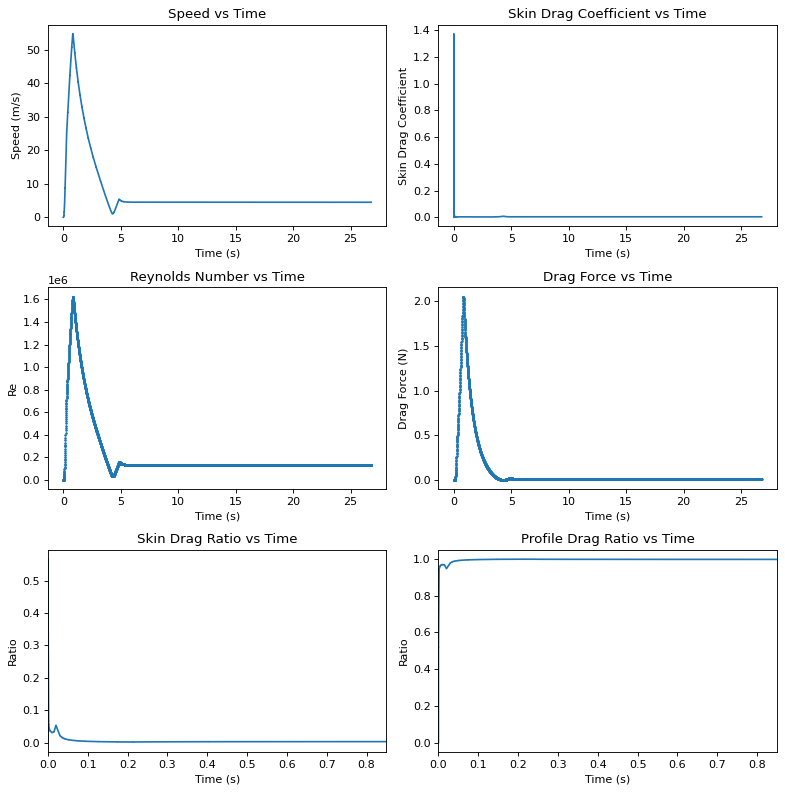

In [37]:
yfig = 10;
xfig = 10;
plt.figure(num=1, figsize=(xfig,yfig), dpi=80)
plt.subplot(321)
plt.plot(rocket["flight_time"],rocket["speed_profile"])
plt.title('Speed vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Speed (m/s)')

plt.figure(num=1, figsize=(xfig,yfig), dpi=80)
plt.subplot(322)
plt.plot(rocket["flight_time"],skinDragCf)
# plt.xlim(0,0.25)
plt.title('Skin Drag Coefficient vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Skin Drag Coefficient')

plt.figure(num=1, figsize=(xfig,yfig), dpi=80)
plt.subplot(323)
plt.scatter(rocket["flight_time"],Re, s=1)
# plt.xlim(0,0.25)
plt.title('Reynolds Number vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Re')

plt.figure(num=1, figsize=(xfig,yfig), dpi=80)
plt.subplot(324)
plt.scatter(rocket["flight_time"], totalDrag, s = 1)
plt.title('Drag Force vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Drag Force (N)')

plt.figure(num=1, figsize=(xfig,yfig), dpi=80)
plt.subplot(325)
plt.plot(rocket["flight_time"],sDr)
plt.xlim(0,solidmotor["burn_time"])
plt.title('Skin Drag Ratio vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Ratio')

plt.figure(num=1, figsize=(xfig,yfig), dpi=80)
plt.subplot(326)
plt.plot(rocket["flight_time"],pDr)
plt.xlim(0,solidmotor["burn_time"])
plt.title('Profile Drag Ratio vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Ratio')
plt.tight_layout()

Solver Time Steps

In [38]:
# time_vecotr = np.linspace(0,len(rocket["flight_time"]),len(rocket["flight_time"]))
# yfig = 12;
# xfig = 18;
# plt.figure(num=1, figsize=(xfig,yfig), dpi=80)
# plt.scatter(time_vecotr,rocket["flight_time"])
# # plt.xlim(10000,10050)
# plt.title('Simulation Time vs Time Step')
# plt.xlabel('count')
# plt.ylabel('Time (s)')
# plt.show()

Motor Thrust over Simulation

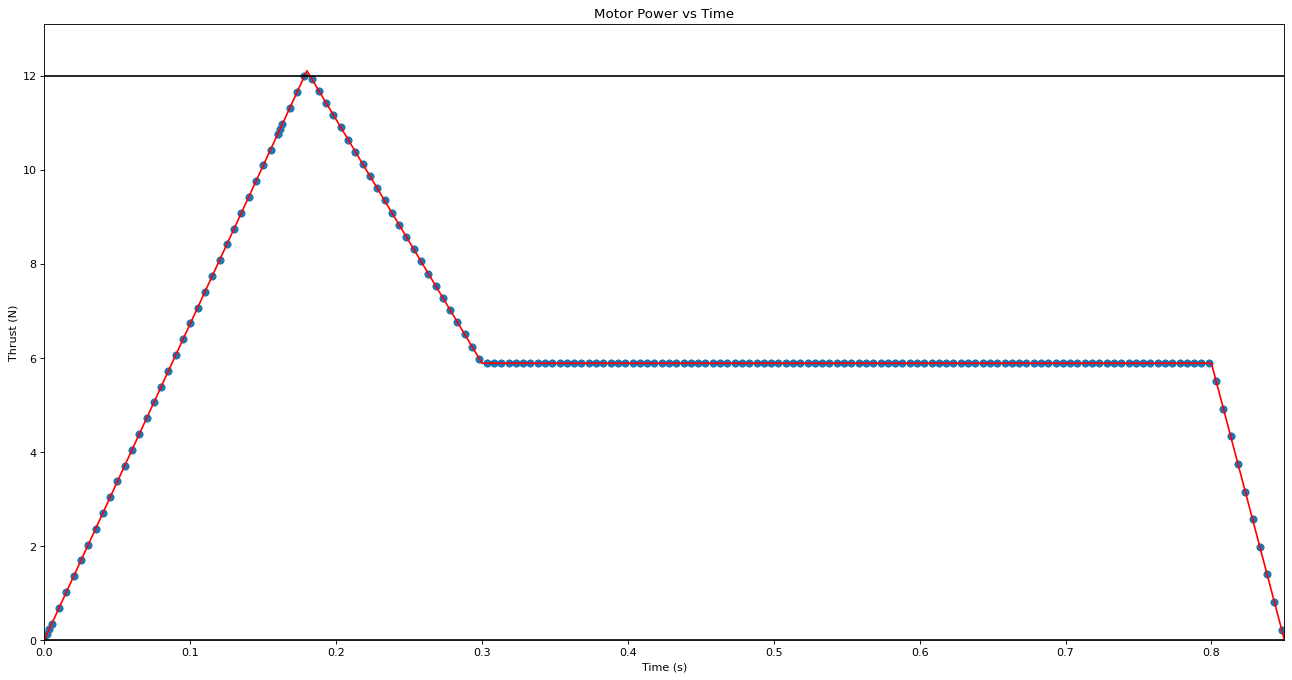

In [39]:
motorPower = np.zeros(len(rocket["flight_time"]));
for i in range (0, len(rocket["flight_time"])):
  motorPower[i] = (ThrustForce(solidmotor["thrust_function"], rocket["flight_time"][i]))

yfig = 10;
xfig = 20;
plt.figure(num=1, figsize=(xfig,yfig), dpi=80)
# plt.subplot(121)
# plt.axhline(0, color='red')
plt.plot(solidmotor["thrust_function"][:,0], solidmotor["thrust_function"][:,1],color = 'red')
plt.ylim(0,solidmotor["max_thrust"] + 1)
plt.xlim(0,solidmotor["burn_time"])
plt.title('Motor Thrust vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Thrust (N)')


plt.figure(num=1, figsize=(xfig,yfig), dpi=80)
# plt.subplot(122)
plt.axhline(0, color='black')
plt.axhline(12, color='black')
plt.scatter(rocket["flight_time"],motorPower)
plt.title('Motor Power vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Thrust (N)')

plt.show()

Trajectory Plots

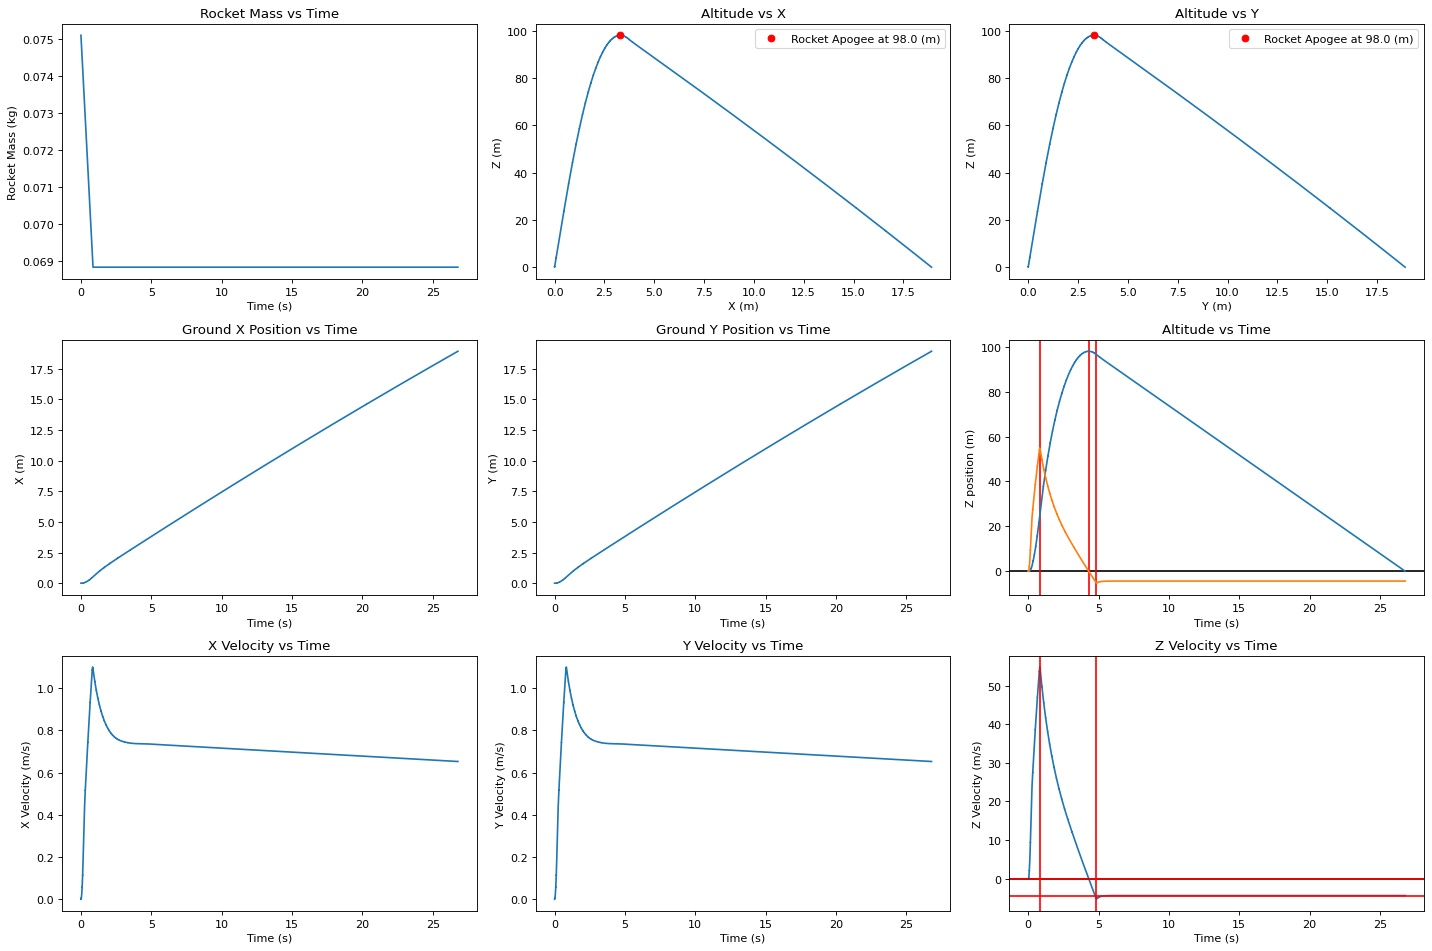

In [40]:
yfig = 12;
xfig = 18;

plt.figure(num=1, figsize=(xfig,yfig), dpi=80)
plt.subplot(331)
# plt.axhline(0.5, color='red')
plt.plot(rocket["flight_time"],rocket["current_mass"])
plt.title('Rocket Mass vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Rocket Mass (kg)')
#loc="upper right"

plt.figure(num=1, figsize=(xfig,yfig), dpi=80)
plt.subplot(332)
plt.plot(rocket["x_flight_position"], rocket["z_flight_position"])
plt.plot(rocket["x_pos_at_apogee"], rocket["apogee"], 'ro', label="Rocket Apogee at {} (m)".format(round(rocket["apogee"],1)))
plt.legend()
plt.title('Altitude vs X')
plt.xlabel('X (m)')
plt.ylabel('Z (m)')

plt.figure(num=1, figsize=(xfig,yfig), dpi=80)
plt.subplot(333)
plt.plot(rocket["y_flight_position"], rocket["z_flight_position"])
plt.plot(rocket["y_pos_at_apogee"], rocket["apogee"], 'ro', label="Rocket Apogee at {} (m)".format(round(rocket["apogee"],1)))
plt.legend()
plt.title('Altitude vs Y')
plt.xlabel('Y (m)')
plt.ylabel('Z (m)')

plt.figure(num=1, figsize=(xfig,yfig), dpi=80)
plt.subplot(334)
plt.plot(rocket["flight_time"],rocket["x_flight_position"])
plt.title('Ground X Position vs Time')
plt.xlabel('Time (s)')
plt.ylabel('X (m)')

plt.figure(num=1, figsize=(xfig,yfig), dpi=80)
plt.subplot(335)
plt.plot(rocket["flight_time"],rocket["y_flight_position"])
plt.title('Ground Y Position vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Y (m)')

plt.figure(num=1, figsize=(xfig,yfig), dpi=80)
plt.subplot(336)
plt.axhline(0, color='black')
plt.axvline(rocket["time_to_apogee"], color='red')
plt.axvline(solidmotor["burn_time"] + solidmotor["parachute_delay"],color='red')
plt.axvline(solidmotor["burn_time"],color='red')
plt.plot(rocket["flight_time"],rocket["z_flight_position"])
plt.plot(rocket["flight_time"],rocket["z_flight_velocity"])
# plt.ylim(0.25,0.7)
# plt.xlim(0.75,0.15)
plt.title('Altitude vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Z position (m)')

plt.figure(num=1, figsize=(xfig,yfig), dpi=80)
plt.subplot(337)
plt.plot(rocket["flight_time"],rocket["x_flight_velocity"])
plt.title('X Velocity vs Time')
plt.xlabel('Time (s)')
plt.ylabel('X Velocity (m/s)')

plt.figure(num=1, figsize=(xfig,yfig), dpi=80)
plt.subplot(338)
plt.plot(rocket["flight_time"],rocket["y_flight_velocity"])
plt.title('Y Velocity vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Y Velocity (m/s)')

plt.figure(num=1, figsize=(xfig,yfig), dpi=80)
plt.subplot(339)
plt.plot(rocket["flight_time"],rocket["z_flight_velocity"])
plt.axhline(0,color='black')
plt.axvline(solidmotor["burn_time"],color='red')
plt.axvline(solidmotor["burn_time"] + solidmotor["parachute_delay"],color='red')
plt.axhline(-parachute["steady_descent_velocity"], color='red')
plt.axhline(environment["wind_speed"][0], color='red')
plt.title('Z Velocity vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Z Velocity (m/s)')

plt.tight_layout()

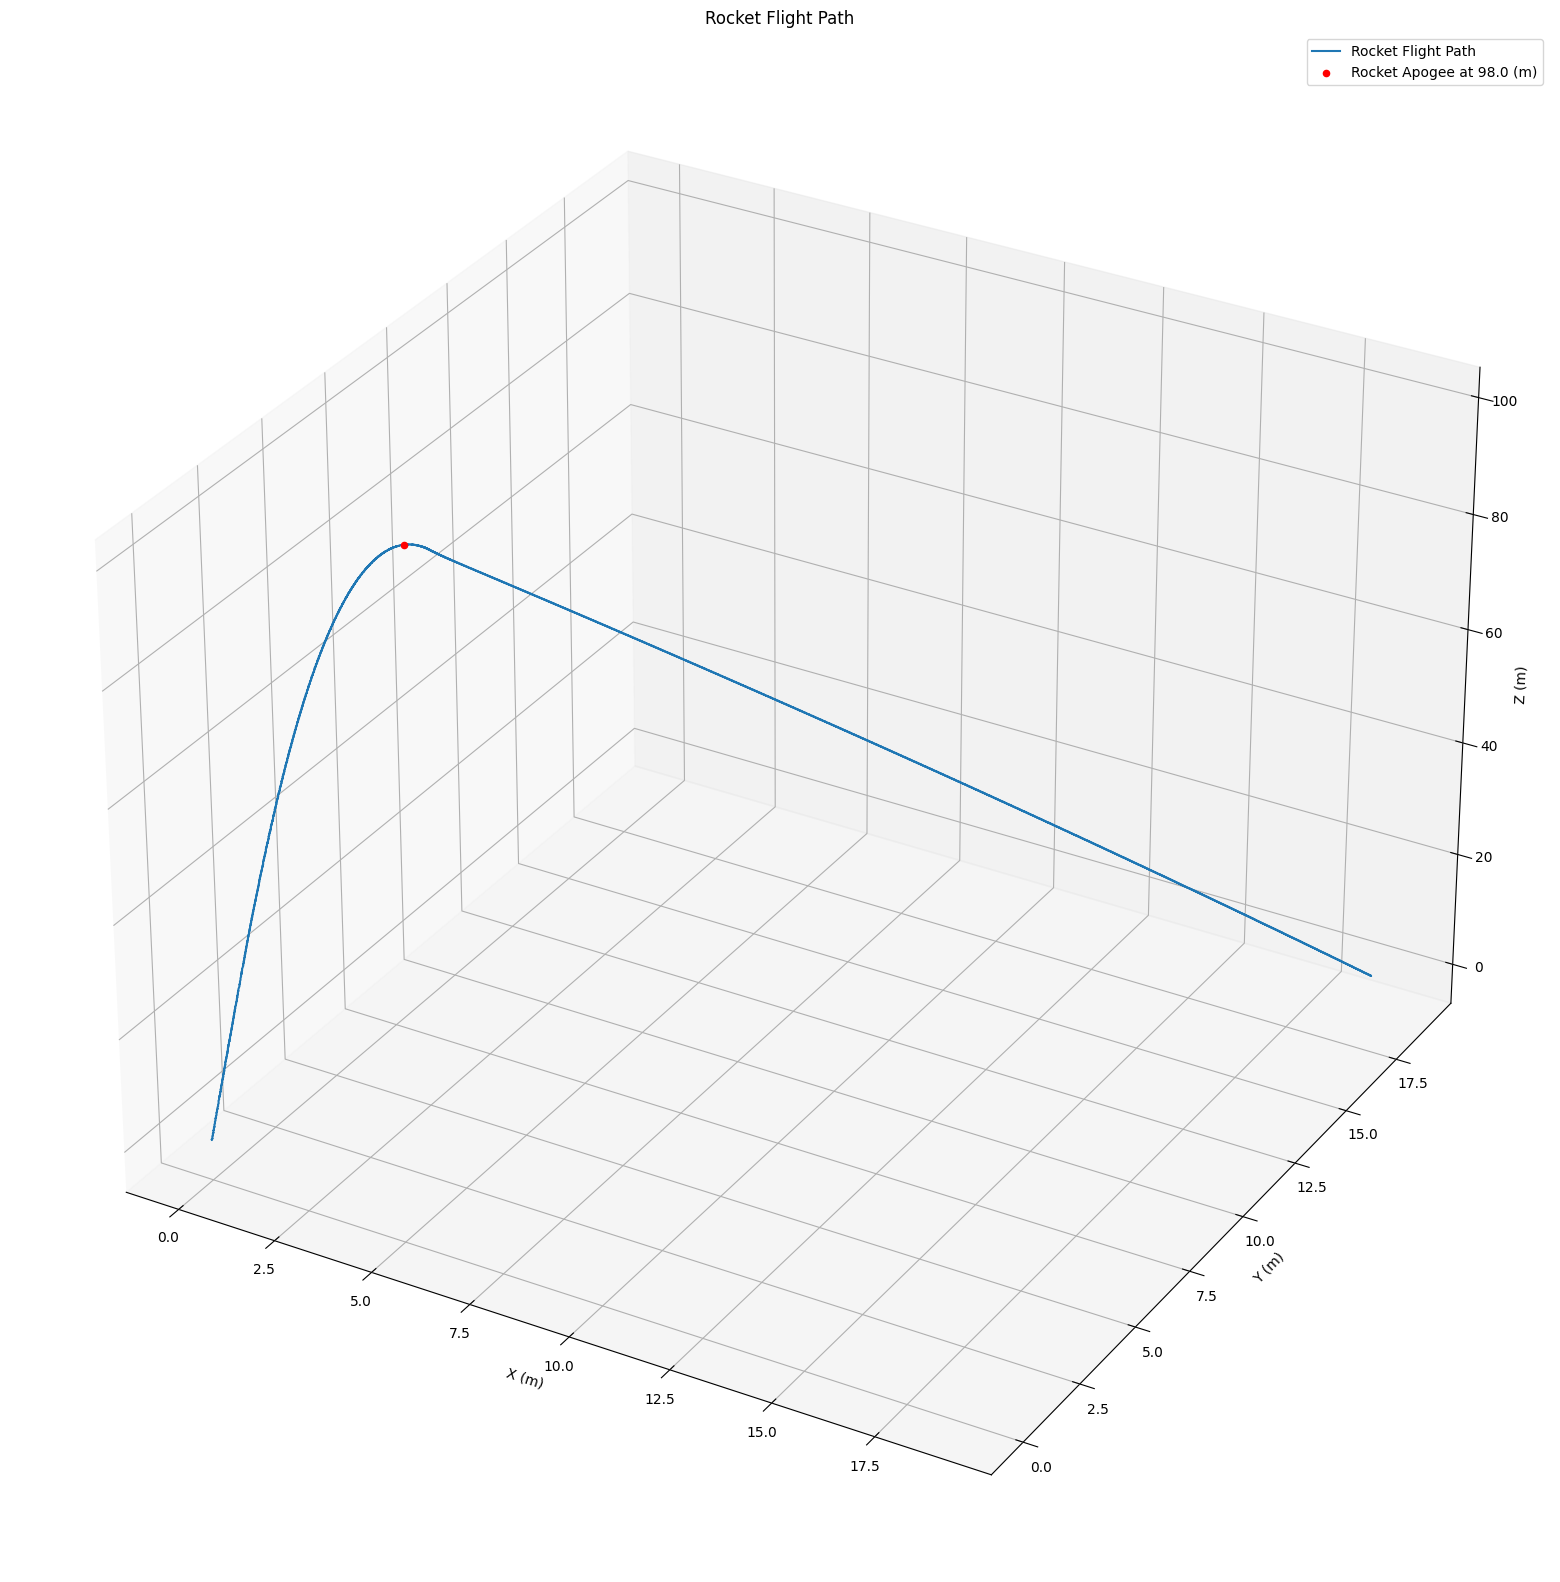

In [41]:
yfig = 20;
xfig = 20;

xline = np.around(rocket["x_flight_position"],2)
yline = np.around(rocket["y_flight_position"],2)
zline = rocket["z_flight_position"]

fig = plt.figure(figsize=(xfig,yfig))
ax = fig.add_subplot(111, projection='3d')
ax.plot(xline,yline,zline, label="Rocket Flight Path")
ax.scatter(rocket["x_pos_at_apogee"],rocket["y_pos_at_apogee"], rocket["apogee"], label="Rocket Apogee at {} (m)".format(round(rocket["apogee"],1)), color='red')
ax.set_title("Rocket Flight Path")
ax.legend()
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
plt.show()

Angle vs Time

In [42]:
rocket["pitch_time"] = np.linspace(0, solidmotor["burn_time"], len(rocket["air_pitch"]))
# print(len())

Graph

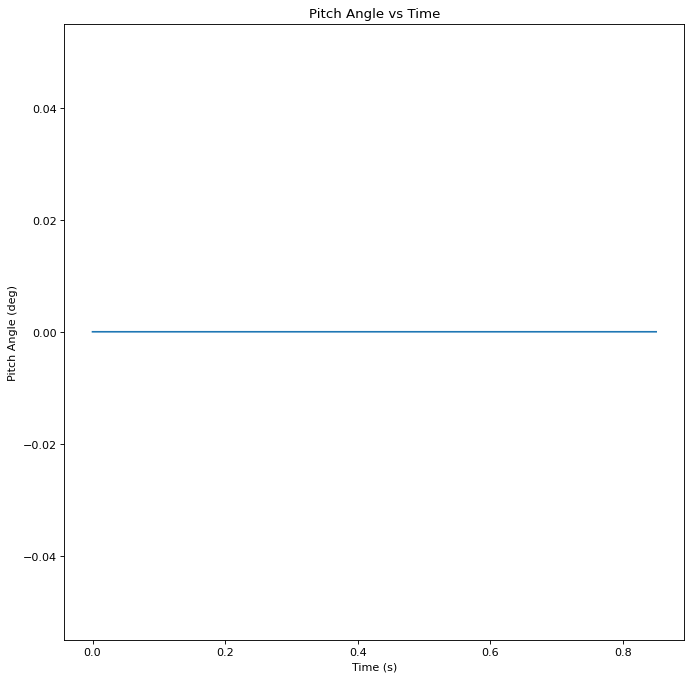

In [43]:
xfig = 10
yfig = 10
plt.figure(num=1, figsize=(xfig,yfig), dpi=80)
plt.plot(rocket["pitch_time"], rocket["air_pitch"])
plt.title('Pitch Angle vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Pitch Angle (deg)')

plt.show()

More Data

In [44]:
velocity = np.linspace(0, 50, 500)
rocketBaseCd = np.zeros(len(velocity))
BaseCd = np.zeros(len(velocity))
BodyCd = np.zeros(len(velocity))
SFBodyCd = np.zeros(len(velocity))

for i in range (0,len(velocity)):
    rocketBaseCd[i] = BaseDragCoefficient(velocity[i], 0)

for i in range (0,len(velocity)):
    SFBodyCd[i] = BodyDragCoefficient(velocity[i], 0)

for i in range (0,len(velocity)):
    BaseCd[i] = BaseDragCoefficient(velocity[i], 1)

for i in range (0,len(velocity)):
    BodyCd[i] = BodyDragCoefficient(velocity[i], 1)




Data

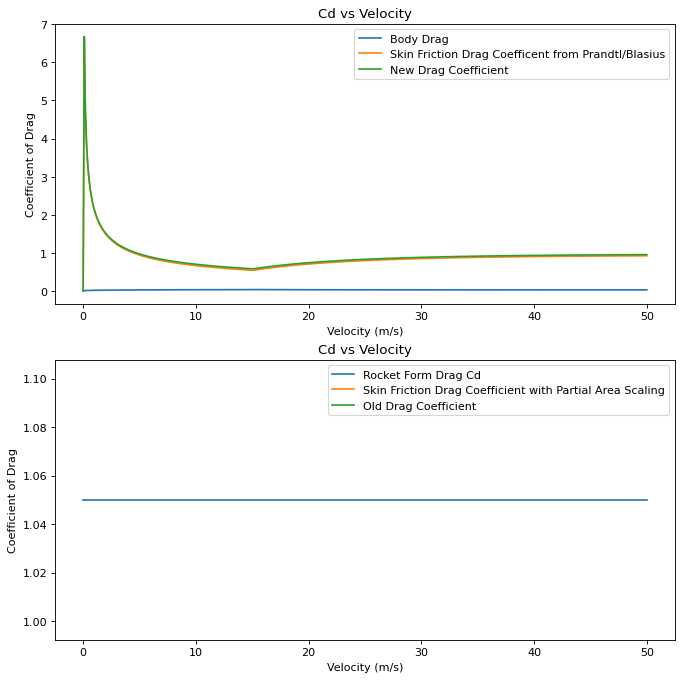

In [45]:
xfig = 10
yfig = 10
plt.figure(num=1, figsize=(xfig,yfig), dpi=80)
plt.subplot(211)
plt.plot(velocity, BaseCd, label='Body Drag')
plt.plot(velocity, BodyCd, label = 'Skin Friction Drag Coefficent from Prandtl/Blasius')
plt.plot(velocity, np.add(BaseCd, BodyCd), label='New Drag Coefficient')
plt.legend()
plt.title('Cd vs Velocity')
plt.xlabel('Velocity (m/s)')
plt.ylabel('Coefficient of Drag')

plt.subplot(212)
plt.plot(velocity, rocketBaseCd, label='Rocket Form Drag Cd')
plt.plot(velocity, SFBodyCd, label='Skin Friction Drag Coefficient with Partial Area Scaling')
plt.plot(velocity, np.add(rocketBaseCd, SFBodyCd), label='Old Drag Coefficient')
plt.legend()
plt.title('Cd vs Velocity')
plt.xlabel('Velocity (m/s)')
plt.ylabel('Coefficient of Drag')

plt.show()